<img align="right" src="images/DSApps_logo_small.jpg">

# DSApps 2023 @ TAU: Assignment 4

### Giora Simchoni

### Network Analysis with NetworkX

### Welcome

Welcome to Assignment 4 in Python!

Remember:

* You can play with the assignment in Playground mode, but:
* Only your private Github repository assigned to you by the course admin will be cloned and graded (Submission mode, see instructions [here](https://github.com/DSApps-2023/Class_Slides/blob/main/Apps_of_DS_HW.pdf))
* Like any other University assignment, your work should remain private
* You need to `git clone` your private Github repository locally as explained [here](https://github.com/DSApps-2023/Class_Slides/blob/main/Apps_of_DS_HW.pdf)
* You need to uncomment the starter code inside the chunk, replace the `### YOUR CODE HERE ###`, run the chunk and see that you're getting the expected result
* Pay attention to what you're asked to do and the required output
* For example, using a *different* function than the one you were specifically asked to use, will decrease your score (unless you amaze me)
* Your notebook should run smoothly from start to end if someone presses in the Jupyter toolbar Kernel --> Restart & Run All
* When you're done save the entire notebook into a html file, this is the file that would be graded
* You can add other files but do not delete any files
* Commit your work and push to your private Github repository as explained [here](https://github.com/DSApps-2023/Class_Slides/blob/main/Apps_of_DS_HW.pdf)

This assignemtnt is due: 18/5 23:59

### Libraries

These are the libraries you will need. If you don't have them, you need to uncomment the `!pip install` line and install them first (you can also just copy this command to a terminal and do it there if you don't want all the output printed in this notebook).

In [3]:
#!pip install matplotlib numpy scipy pandas networkx

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations # not mandatory

### The Films to Actors 2010s Dataset



Often cited articles in the field of Network Analysis are ["Emergence of Scaling in Random Networks"](http://barabasi.com/f/67.pdf) by Barabasi and Albert and ["The Eccentricities of Actors"](https://www.jstor.org/stable/25678151?seq=1) by Harris and Mossinghoff. Both articles deal with a network of film actors in which two actors are connected if they were cast in the same film. The famous [Kevin Bacon Number](https://en.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) is also discussed.

Alas, the data used by these articles were put together somewhere in the late 1990s :(

Can we scrape the web to get an updated version?

We sure can! Checkout the short python script `scraping_films_actors_2010s.py` in which I used one of Python's most popular library for scraping the web [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), to scrape [Wikipedia](https://en.wikipedia.org/wiki/List_of_American_films_of_2010) for most popular films in the 2010s (2010-2019) and their cast.

The script isn't perfect, the data aren't perfect, as you will undoubtedly see - but they're good enough for us. For example Wikipedia only lists "main" actors on cast (A-list, sort of), for a more extensive list one could go to scrape [IMDB](https://www.imdb.com/).

Few important notes if you're interested in web scraping (if not - go on):

* You can use the script if you want to increase the span of years, e.g. to 2000-2019, but it is only guaranteed to work for 2010-2019, those 10 Wikipedia pages, on 3/3/2020 (Yes, they can change!)
* Even between 2010 and 2019 if you look closely at the script there are differences in structure
* With great power comes great responsibility - there's ethics to web scraping, please don't bombard Wikipedia or any other site with thousands of requests, they might crash or punish you and rightly so! See e.g. [here](https://towardsdatascience.com/ethics-in-web-scraping-b96b18136f01).

Read in the data, it is pretty self explanatory:

In [8]:
films_actors_edgelist = pd.read_csv('data/films_actors_edgelist_2010s.csv', usecols=['film', 'actor', 'year'])

### Basic Data Exploration

###### (0 points)

Data dimensions:

In [9]:
films_actors_edgelist.shape

(12352, 3)

Peek at the data:

In [34]:
films_actors_edgelist.head(5)

,film,actor,year
0,127 Hours,James Franco,2010
1,127 Hours,Amber Tamblyn,2010
2,127 Hours,Kate Mara,2010
3,127 Hours,Clémence Poésy,2010
4,127 Hours,Lizzy Caplan,2010


Top actors (no. of films):

In [35]:
films_actors_edgelist.groupby('actor').size().sort_values(ascending=False).head(10)

actor
Dwayne Johnson    23
Liam Neeson       21
Kristen Wiig      21
James Franco      21
Idris Elba        20
Michael Peña      20
Stanley Tucci     20
Anthony Mackie    19
Robert De Niro    19
Kevin Hart        19
dtype: int64

Notice the only actress in this group is Kristen Wiig. She had a film released every year excluding 2015 and 2018:

In [10]:
films_actors_edgelist.query('actor == "Kristen Wiig"').sort_values('year')

,film,actor,year
36,All Good Things,Kristen Wiig,2010
219,Despicable Me,Kristen Wiig,2010
471,How to Train Your Dragon,Kristen Wiig,2010
690,MacGruber,Kristen Wiig,2010
1431,Bridesmaids,Kristen Wiig,2011
2259,Paul,Kristen Wiig,2011
3541,Friends with Kids,Kristen Wiig,2012
6143,The Secret Life of Walter Mitty,Kristen Wiig,2013
5261,Girl Most Likely,Kristen Wiig,2013
5375,"Hateship, Loveship",Kristen Wiig,2013


But these are extremes. You can see that over 50% of the 4,742 actors in the list have only 1 film:

In [11]:
films_actors_edgelist.groupby('actor').size().describe()

count    4743.000000
mean        2.604259
std         2.977782
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        23.000000
dtype: float64

See top films (size of cast):

In [38]:
films_actors_edgelist.groupby('film').size().sort_values(ascending=False).head(10)

film
Anchorman 2: The Legend Continues            32
The Twilight Saga: Breaking Dawn - Part 2    31
Cars 2                                       30
Avengers: Infinity War                       27
Grown Ups 2                                  26
Toy Story 3                                  26
Ice Age: Continental Drift                   23
Argo                                         22
Movie 43                                     22
Django Unchained                             22
dtype: int64

Anchorman 2 has a cast of 32 A list actors?

In [12]:
films_actors_edgelist.loc[films_actors_edgelist['film'].str.startswith("Anchorman 2"), 'actor'].to_list()

['Will Ferrell',
 'Christina Applegate',
 'Paul Rudd',
 'David Koechner',
 'Steve Carell',
 'Kristen Wiig',
 'James Marsden',
 'Dylan Baker',
 'Meagan Good',
 'Harrison Ford',
 'Greg Kinnear',
 'Josh Lawson',
 'Vince Vaughn',
 'Luke Wilson',
 'Nicole Kidman',
 'Fred Willard',
 'Chris Parnell',
 'Fred Armisen',
 'Jim Carrey',
 'Sacha Baron Cohen',
 'Drake',
 'Kirsten Dunst',
 'Tina Fey',
 'Will Smith',
 'Liam Neeson',
 'Amy Poehler',
 'Kanye West',
 'Billie Joe Armstrong',
 'Mike Dirnt',
 'Tré Cool',
 'Jason White',
 'Lewis Hamilton']

But these are extremes. You can see a film on this list typically has up to 7 named actors:

In [39]:
films_actors_edgelist.groupby('film').size().describe()

count    2194.000000
mean        5.629900
std         3.389415
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        32.000000
dtype: float64

### Creating the Network

##### (20 points)

Your task is to create the network of actors.

* Call it `A`
* Your network should be undirected and unweighted, i.e. if two actors were cast in at least one film together they are connected by an edge
* No self edges obviously, no multi-edges
* Be careful not to "lose" an actor/actress who was cast in a single film in which he/she are the **only** cast members
* There are numerous ways to do this, I provided hints, **YOU ONLY NEED TO IMPLEMENT ONE**

In [4]:
# Some sanity check function to help you:
def print_network_info(G):
    print('no. of nodes: %d' % G.number_of_nodes())
    print('no. of edges: %d' % G.number_of_edges())
    print('no. of James Franco neighbors: %d' % len(list(G.neighbors('James Franco'))))

In [12]:
# method 1: converting our DF into a <film --> actors list> dictionary, then iterating through that dictionary,
# adding an edge between every combination of 2 actors
#
films_dict = films_actors_edgelist.groupby('film')['actor'].apply(list).to_dict()
A = nx.Graph()

for actors in films_dict.values():
    A.add_nodes_from(actors)

for actors in films_dict.values():
    for i in range(len(actors)):
        for j in range(i+1, len(actors)):
            A.add_edge(actors[i], actors[j])

print_network_info(A)

no. of nodes: 4743
no. of edges: 39319
no. of James Franco neighbors: 107


In [16]:
# method 2: use NetworkX bipartite.projected_graph() function


In [17]:
# method 3 (slowest and least recommended):
# convert our DF into a films X actors 0/1 incidence matrix (e.g. with pivot_table()),
# then either:
# (1) compute the projected actors co-occurence matrix manually, then use NetworkX from_numpy_array() reading function
# (2) use NetworkX bipartite.from_biadjacency_matrix() function, then bipartite.projected_graph()
#
# ### YOUR CODE HERE
# print_network_info(A)

### Basic Network Exploration

##### (20 points)

What is the average, median minimum and maximum degree of the network?

In [42]:
A_degrees = list(dict(A.degree).values())

print('Mean degree: %.2f' % np.mean(A_degrees))
print('Median degree: %.2f' % np.median(A_degrees))
print('Max degree: %.2f' % np.max(A_degrees))
print('Min degree: %.2f' % np.min(A_degrees))

Mean degree: 16.58
Median degree: 9.00
Max degree: 146.00
Min degree: 0.00


Who are the 10 actors with highest degrees?

In [43]:
degree_lst = list(A.degree)
sorted_degree= sorted(degree_lst, key = lambda x: x[1] ,reverse = True) 
highest_ten = sorted_degree[:10]
actors = [tup[0] for tup in highest_ten]
actors

['Liam Neeson',
 'Michael Peña',
 'Bryan Cranston',
 'John Goodman',
 'Owen Wilson',
 'Kristen Bell',
 'Nicole Kidman',
 'Bradley Cooper',
 'Steve Carell',
 'Elizabeth Banks']

Plot the degree histogram of the network (doesn't have to be pretty).

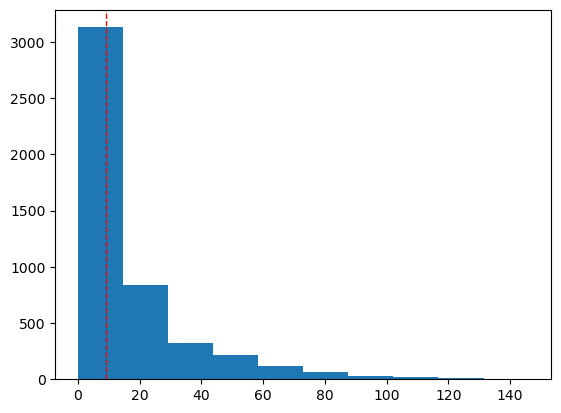

In [44]:
plt.hist(A_degrees)
median = np.median(A_degrees)
plt.axvline(median, color='r', linestyle='dashed', linewidth=1)
# we add the median for check ourselvs

Plot the network (doesn't have to be pretty).

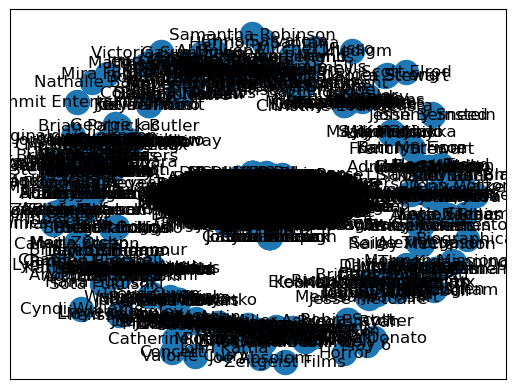

In [45]:
nx.draw_networkx(A)


Check if the network is connected:

In [46]:
print(nx.is_connected(A))

False


How many components are there?

In [47]:
nx.number_connected_components(A)

122

What is the size of the largest component?

In [50]:
largest_comp = A.subgraph(max(nx.connected_components(A), key = len))
len(largest_comp)

4388

Plot the largest component (doesn't have to be pretty).

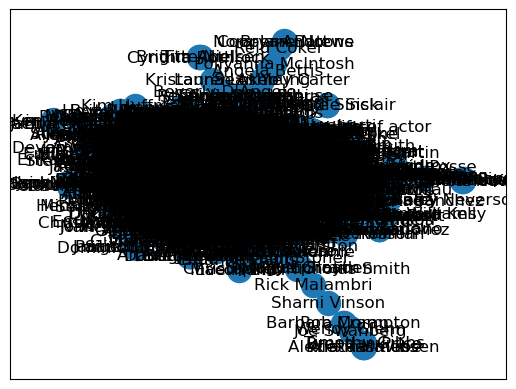

In [51]:
nx.draw_networkx(largest_comp)

### James Franco Number

##### (15 points)

In the 1990s they were interested in the [Kevin Bacon Number](https://simple.wikipedia.org/wiki/Bacon_number) which on a graph like ours would be the length of the shortest path between a given actress and Kevin Bacon. Also see [The Oracle of Bacon](https://oracleofbacon.org/how.php).

Let's do the same with the first actor on our list: James Franco!

Use `nx.shortest_path_length` to calculate all James Franco numbers in our graph. Notice NetworkX will calculate this only for James Franco's component, which is good enough for us, but think about what would be the shortest path to unconnected actors and what does this mean about the average you will be getting below.

In [13]:
james_franco_number = []
james_component = nx.node_connected_component(A, 'James Franco')
for node in james_component:
    james_franco_number.append(nx.shortest_path_length(A, 'James Franco', node))
#james_franco_number

What is the average, median, minimum and maximum James Franco number?

In [25]:
print('Mean james_franco_number: %.2f' % np.mean(james_franco_number))
print('Median james_franco_number: %.2f' % np.median(james_franco_number))
print('Max james_franco_number: %.2f' % np.max(james_franco_number))
print('Min james_franco_number: %.2f' % np.min(james_franco_number))

Mean james_franco_number: 2.64
Median james_franco_number: 3.00
Max james_franco_number: 7.00
Min james_franco_number: 0.00


What is the percentage of actors having James Franco Number of 3 or less?

In [26]:
sum_less_than_3 = 0
for i in range(len(james_franco_number)):
    if james_franco_number[i] <= 3:
        sum_less_than_3 += 1
print(sum_less_than_3 / len(james_franco_number) * 100 , "%")

92.41112123974476 %


### Centrality

##### (15 points)

Compute the Degree, Eigen, Pagerank, Closeness and Betweenness centralities (may take some time):

In [34]:
cent_deg = nx.degree_centrality(A)
cent_eig = nx.eigenvector_centrality(A)
cent_pagerank = nx.pagerank(A)
cent_closeness = nx.closeness_centrality(A)
cent_betweenness = nx.betweenness_centrality(A)


Run this chunk to create a DataFrame with 5 columns, one for every centrality measure, and an `actor` column:

In [35]:
cent_df = pd.DataFrame([cent_deg, cent_eig, cent_pagerank, cent_closeness, cent_betweenness]).T.reset_index()
cent_df.columns = ['actor', 'degree', 'eigen', 'pagerank', 'closeness', 'betweenness']
cent_df[cent_df['actor'].isin(['Meryl Streep', 'Liam Neeson', 'James Franco', 'Cate Blanchett'])]

,actor,degree,eigen,pagerank,closeness,betweenness
35,James Franco,0.022564,0.051441,0.001038,0.350603,0.007604
341,Liam Neeson,0.030789,0.094411,0.001342,0.357836,0.011891
832,Meryl Streep,0.011388,0.031699,0.000496,0.326436,0.001240
1216,Cate Blanchett,0.012653,0.036013,0.000580,0.325076,0.001890


Use `cent_df` to print the top 5 central actors for every centrality measure:

In [36]:
for cent in cent_df.columns[1:]:
    print('Centrality %s:' % cent)
    print(cent_df.sort_values(cent, ascending=False)['actor'].head(5))
    print()

Centrality degree:
341        Liam Neeson
19        Michael Peña
711     Bryan Cranston
3         John Goodman
1453       Owen Wilson
Name: actor, dtype: object

Centrality eigen:
411         Paul Rudd
323    Bradley Cooper
341       Liam Neeson
481      Steve Carell
511      Kristen Wiig
Name: actor, dtype: object

Centrality pagerank:
19       Michael Peña
341       Liam Neeson
711    Bryan Cranston
189      Kristen Bell
3        John Goodman
Name: actor, dtype: object

Centrality closeness:
528          Emma Stone
19         Michael Peña
1320    Elizabeth Banks
341         Liam Neeson
323      Bradley Cooper
Name: actor, dtype: object

Centrality betweenness:
19       Michael Peña
341       Liam Neeson
711    Bryan Cranston
189      Kristen Bell
390    Anthony Mackie
Name: actor, dtype: object



**Do you see the actor which is in the top 5 centrality by any measure? Look at this actor's films list and write why he's so central.**

In [79]:
films_liam = films_actors_edgelist.query('actor == "Liam Neeson"').iloc[:,0]
films_liam_list = list(films_liam)
filtered_df = films_actors_edgelist[films_actors_edgelist['film'].isin(films_liam_list)]
filtered_df.groupby('film').size().describe()
#films_actors_edgelist.groupby('film').size().describe()

# we can see that in every parameter the amount of actors is higher in Liam's films as opposed to all the actors.
# in addition, we saw that Liam's degree is 146 (which is the maximal degree) . that lead us to conclude that liam's films are with large cast and that in this films there are also unknown actors that are making him so central.

count    2194.000000
mean        5.629900
std         3.389415
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        32.000000
dtype: float64

### Community Detection

##### (15 points)

Use the Louvain method to detect communities of actors in **the giant component** of our network. Use `seed=42`.

In [96]:
np.random.seed(42)
giant_comp_subG = A.subgraph(largest_comp)
communities = nx.community.louvain_communities(giant_comp_subG)

[{'Adeel Akhtar',
  'Alan Ritchson',
  'Alec Baldwin',
  'America Ferrera',
  'Amrita Acharia',
  'Amy Poehler',
  'Andrea Savage',
  'Aneurin Barnard',
  'Angela Sarafyan',
  'Anjul Nigam',
  'Anna Faris',
  'Ariel Winter',
  'Art Evans',
  'Bette Midler',
  'Betty White',
  'Billie Joe Armstrong',
  'Bobby Lee',
  'Brian Huskey',
  'Briga Heelan',
  'Brighton Sharbino',
  'Bruno Ganz',
  'Cas Anvar',
  'Cassie Ventura',
  'Chris Brown',
  "Chris O'Donnell",
  'Chris Parnell',
  'Chris Renaud',
  'Christina Applegate',
  'Christine Lakin',
  'Christine Woods',
  'Dan Aykroyd',
  'Dana Carvey',
  'Dana Gaier',
  'Daniel Sunjata',
  'Danny Pudi',
  'Darius McCrary',
  'David Cross',
  'David Koechner',
  'David Selby',
  'David Walliams',
  'Debbie Reynolds',
  'Demetri Martin',
  'Demi Lovato',
  'Derek Luke',
  'Diane Kruger',
  'Dondre Whitfield',
  'Drake',
  'Dwight Yoakam',
  'Dylan Baker',
  'Edwina Findley',
  'Eiza Gonzalez',
  'Ellie Kemper',
  'Enrico Colantoni',
  'Eric Andr

What is the modularity of the partition found by the algorithm?

In [98]:
print(nx.community.modularity(giant_comp_subG, communities))

0.46140127445898266


How many communities were found by the Louvain method? What is the average, median, minimum and maximum community size?

In [99]:
num_communities = len(communities)
print(f"Number of communities: {num_communities}")
community_sizes = [len(c) for c in communities]

avg_size = np.mean(community_sizes)
median_size = np.median(community_sizes)
min_size = np.min(community_sizes)
max_size = np.max(community_sizes)

print(f"Average community size: {avg_size}")
print(f"Median community size: {median_size}")
print(f"Minimum community size: {min_size}")
print(f"Maximum community size: {max_size}")

Number of communities: 30
Average community size: 146.26666666666668
Median community size: 135.0
Minimum community size: 23
Maximum community size: 340


In order to make some sense of the community structure found by the Louvain method, let us filter for each community only A-list actors, e.g. actors with at least 5 films in the decade. Also sort the actors alphabetically in each list:

In [107]:
actor2n_films = films_actors_edgelist.groupby('actor').size().to_dict()
a_list = [actor for actor, n_films in actor2n_films.items() if n_films >= 5]
print('Found %d actors with at least 5 films' % len(a_list))

communities_a_list = []
for i, comm in enumerate(communities):
    filtered_nodes = sorted(list(set(comm) & set(a_list)))
    communities_a_list.append(filtered_nodes)

Found 722 actors with at least 5 films


[['Alec Baldwin',
  'America Ferrera',
  'Amy Poehler',
  'Anna Faris',
  'Ariel Winter',
  'Christina Applegate',
  'David Cross',
  'David Koechner',
  'Derek Luke',
  'Diane Kruger',
  'Frank Langella',
  'Fred Armisen',
  'Gabrielle Union',
  'Greg Kinnear',
  'Harrison Ford',
  'Jack McBrayer',
  'James Marsden',
  'Jay Baruchel',
  'Jemaine Clement',
  'Jenny Slate',
  'Jim Carrey',
  'Justin Long',
  'Kevin Hart',
  'Kevin Kline',
  'Kirsten Dunst',
  'Kristen Wiig',
  'Lake Bell',
  'Liam Neeson',
  'Lucy Punch',
  'Luke Wilson',
  'Mary Steenburgen',
  'Meagan Good',
  'Megan Fox',
  'Michael Ealy',
  'Michiel Huisman',
  'Nick Kroll',
  'Nick Nolte',
  'Nicole Kidman',
  'Patton Oswalt',
  'Paul Rudd',
  'Regina Hall',
  'Reid Scott',
  'Steve Carell',
  'Teresa Palmer',
  'Tiffany Haddish',
  'Tika Sumpter',
  'Tina Fey',
  'Tommy Lee Jones',
  'Ty Burrell',
  'Vince Vaughn',
  'Will Ferrell',
  'Will Smith',
  'Zach Galifianakis'],
 ['Alan Rickman',
  'Andrew Garfield',
  '

For each community filtered print its actors:

In [108]:
for actors in communities_a_list:
    if len(actors) > 10:
        print(actors)
        print()

['Alec Baldwin', 'America Ferrera', 'Amy Poehler', 'Anna Faris', 'Ariel Winter', 'Christina Applegate', 'David Cross', 'David Koechner', 'Derek Luke', 'Diane Kruger', 'Frank Langella', 'Fred Armisen', 'Gabrielle Union', 'Greg Kinnear', 'Harrison Ford', 'Jack McBrayer', 'James Marsden', 'Jay Baruchel', 'Jemaine Clement', 'Jenny Slate', 'Jim Carrey', 'Justin Long', 'Kevin Hart', 'Kevin Kline', 'Kirsten Dunst', 'Kristen Wiig', 'Lake Bell', 'Liam Neeson', 'Lucy Punch', 'Luke Wilson', 'Mary Steenburgen', 'Meagan Good', 'Megan Fox', 'Michael Ealy', 'Michiel Huisman', 'Nick Kroll', 'Nick Nolte', 'Nicole Kidman', 'Patton Oswalt', 'Paul Rudd', 'Regina Hall', 'Reid Scott', 'Steve Carell', 'Teresa Palmer', 'Tiffany Haddish', 'Tika Sumpter', 'Tina Fey', 'Tommy Lee Jones', 'Ty Burrell', 'Vince Vaughn', 'Will Ferrell', 'Will Smith', 'Zach Galifianakis']

['Alan Rickman', 'Andrew Garfield', 'Angelina Jolie', 'Anya Taylor-Joy', 'Bill Nighy', 'Boyd Holbrook', 'Britt Robertson', 'Catherine Zeta-Jones', 

It's extremely hard to make sense of the communities and some of them don't really make sense, but if you followed thus far, you can see a few interesting ones.

Write a function which takes an A-list actor's name, and returns the (A-list) community to which this actor belongs (or an empty list of the actor was not found):

In [110]:
def get_actor_community(actor):
    for comm in communities_a_list:
        if actor in comm:
            return comm
    return []

['Alec Baldwin', 'America Ferrera', 'Amy Poehler', 'Anna Faris', 'Ariel Winter', 'Christina Applegate', 'David Cross', 'David Koechner', 'Derek Luke', 'Diane Kruger', 'Frank Langella', 'Fred Armisen', 'Gabrielle Union', 'Greg Kinnear', 'Harrison Ford', 'Jack McBrayer', 'James Marsden', 'Jay Baruchel', 'Jemaine Clement', 'Jenny Slate', 'Jim Carrey', 'Justin Long', 'Kevin Hart', 'Kevin Kline', 'Kirsten Dunst', 'Kristen Wiig', 'Lake Bell', 'Liam Neeson', 'Lucy Punch', 'Luke Wilson', 'Mary Steenburgen', 'Meagan Good', 'Megan Fox', 'Michael Ealy', 'Michiel Huisman', 'Nick Kroll', 'Nick Nolte', 'Nicole Kidman', 'Patton Oswalt', 'Paul Rudd', 'Regina Hall', 'Reid Scott', 'Steve Carell', 'Teresa Palmer', 'Tiffany Haddish', 'Tika Sumpter', 'Tina Fey', 'Tommy Lee Jones', 'Ty Burrell', 'Vince Vaughn', 'Will Ferrell', 'Will Smith', 'Zach Galifianakis']


The Scarlett Johansson community looks like a "blockbuster" community, with all the Marvel stars (Chris Hemsworth, Chris Prat, Benedict Cumberbatch, Chadwick Boseman, Brie Larson, Idris Elba, Mark Ruffalo etc.).

In [111]:
get_actor_community('Scarlett Johansson')

['Adam Driver',
 'Adewale Akinnuoye-Agbaje',
 'Andy Serkis',
 'Anthony Hopkins',
 'Anthony Mackie',
 'Ari Graynor',
 'Benedict Cumberbatch',
 'Benicio del Toro',
 'Bradley Cooper',
 'Brie Larson',
 'Bruce Greenwood',
 'Chadwick Boseman',
 'Charlie Day',
 'Charlie Hunnam',
 'Chris Evans',
 'Chris Hemsworth',
 'Chris Pratt',
 'Christopher Plummer',
 'Cillian Murphy',
 'Cliff Curtis',
 'Daisy Ridley',
 'Dave Bautista',
 'Dennis Quaid',
 'Dev Patel',
 'Domhnall Gleeson',
 'Don Cheadle',
 'Elizabeth Debicki',
 'Elizabeth Olsen',
 'Ewan McGregor',
 'Forest Whitaker',
 'Gwyneth Paltrow',
 'Idris Elba',
 'Jeff Goldblum',
 'Jeremy Irons',
 'John Boyega',
 'Jon Favreau',
 'Josh Brolin',
 'Karen Gillan',
 'Karl Urban',
 'Keira Knightley',
 'Kumail Nanjiani',
 'Laura Dern',
 "Lupita Nyong'o",
 'Mark Hamill',
 'Mark Ruffalo',
 'Martin Freeman',
 'Natalie Portman',
 'Olivia Wilde',
 'Oscar Isaac',
 'Paul Bettany',
 'Peter Dinklage',
 'Rebecca Ferguson',
 'Rene Russo',
 'Robin Wright',
 'Ryan Gosling

The Tina Fey community looks like a "softer" films community, it includes Amy Poehler, Jim Carrey, Paul Rudd, Will Ferrell, etc.

In [112]:
get_actor_community('Tina Fey')

['Alec Baldwin',
 'America Ferrera',
 'Amy Poehler',
 'Anna Faris',
 'Ariel Winter',
 'Christina Applegate',
 'David Cross',
 'David Koechner',
 'Derek Luke',
 'Diane Kruger',
 'Frank Langella',
 'Fred Armisen',
 'Gabrielle Union',
 'Greg Kinnear',
 'Harrison Ford',
 'Jack McBrayer',
 'James Marsden',
 'Jay Baruchel',
 'Jemaine Clement',
 'Jenny Slate',
 'Jim Carrey',
 'Justin Long',
 'Kevin Hart',
 'Kevin Kline',
 'Kirsten Dunst',
 'Kristen Wiig',
 'Lake Bell',
 'Liam Neeson',
 'Lucy Punch',
 'Luke Wilson',
 'Mary Steenburgen',
 'Meagan Good',
 'Megan Fox',
 'Michael Ealy',
 'Michiel Huisman',
 'Nick Kroll',
 'Nick Nolte',
 'Nicole Kidman',
 'Patton Oswalt',
 'Paul Rudd',
 'Regina Hall',
 'Reid Scott',
 'Steve Carell',
 'Teresa Palmer',
 'Tiffany Haddish',
 'Tika Sumpter',
 'Tina Fey',
 'Tommy Lee Jones',
 'Ty Burrell',
 'Vince Vaughn',
 'Will Ferrell',
 'Will Smith',
 'Zach Galifianakis']

The Helena Bonham Carter community looks like the "Brits" community, it includes: Alan Rickman, Emily Blunt, Hugh Laurie, Emma Watson, Daniel Radcliffe, Ralph Fiennes, Maggie Smith etc.

In [113]:
get_actor_community('Helena Bonham Carter')

['Alan Rickman',
 'Andrew Garfield',
 'Angelina Jolie',
 'Anya Taylor-Joy',
 'Bill Nighy',
 'Boyd Holbrook',
 'Britt Robertson',
 'Catherine Zeta-Jones',
 'Chiwetel Ejiofor',
 'Claire Foy',
 'Craig Ferguson',
 'Dan Fogler',
 'Daniel Radcliffe',
 'Danny Huston',
 'Ed Skrein',
 'Eddie Redmayne',
 'Elle Fanning',
 'Emily Blunt',
 'Emma Thompson',
 'Emma Watson',
 'Gemma Arterton',
 'George Clooney',
 'Helena Bonham Carter',
 'Hugh Laurie',
 'Imelda Staunton',
 'James McAvoy',
 'Jason Statham',
 'Johnny Depp',
 'Jude Law',
 'Julie Walters',
 'Juno Temple',
 'Justin Bartha',
 'Katherine Waterston',
 'Logan Lerman',
 'Maggie Smith',
 'Malin Åkerman',
 'Matt Damon',
 'Matt Lucas',
 'Matthew Lillard',
 'Nicholas Hoult',
 'Oliver Platt',
 'Patrick Stewart',
 'Ralph Fiennes',
 'Rebecca Hall',
 'Rhys Ifans',
 'Richard Gere',
 'Sam Worthington',
 'Stana Katic',
 'Stephen Merchant',
 'Thomas Haden Church']

**Not all communities make sense**

For example Daisy Ridley's community incorporates her Star Wars colleagues (Mark Hamill, John Boyega, Adam Driver), but also... Jenna Fischer and Laura Dern.

In [114]:
get_actor_community('Daisy Ridley')

['Adam Driver',
 'Adewale Akinnuoye-Agbaje',
 'Andy Serkis',
 'Anthony Hopkins',
 'Anthony Mackie',
 'Ari Graynor',
 'Benedict Cumberbatch',
 'Benicio del Toro',
 'Bradley Cooper',
 'Brie Larson',
 'Bruce Greenwood',
 'Chadwick Boseman',
 'Charlie Day',
 'Charlie Hunnam',
 'Chris Evans',
 'Chris Hemsworth',
 'Chris Pratt',
 'Christopher Plummer',
 'Cillian Murphy',
 'Cliff Curtis',
 'Daisy Ridley',
 'Dave Bautista',
 'Dennis Quaid',
 'Dev Patel',
 'Domhnall Gleeson',
 'Don Cheadle',
 'Elizabeth Debicki',
 'Elizabeth Olsen',
 'Ewan McGregor',
 'Forest Whitaker',
 'Gwyneth Paltrow',
 'Idris Elba',
 'Jeff Goldblum',
 'Jeremy Irons',
 'John Boyega',
 'Jon Favreau',
 'Josh Brolin',
 'Karen Gillan',
 'Karl Urban',
 'Keira Knightley',
 'Kumail Nanjiani',
 'Laura Dern',
 "Lupita Nyong'o",
 'Mark Hamill',
 'Mark Ruffalo',
 'Martin Freeman',
 'Natalie Portman',
 'Olivia Wilde',
 'Oscar Isaac',
 'Paul Bettany',
 'Peter Dinklage',
 'Rebecca Ferguson',
 'Rene Russo',
 'Robin Wright',
 'Ryan Gosling

### Paper questions

##### (15 points)

Read Overgoor et. al. [Structure of U.S. College Networks on Facebook](https://ojs.aaai.org/index.php/ICWSM/article/view/7318) AAAI 2020 paper, first 6 pages (of course you're invited to read the whole thing!)

What is the density of the US college networks graph (it's a simple computation)?

In [5]:
million = 1000000
n = 7.6 * million
m = (232.5 + 320.1 + 756.5) * million
density = (2 * m) / (n * (n-1))
density

4.532895333275702e-05

In your own up to 100 words, what is described in Figure 6? Copy pasting from the paper will lead to zero points.

In [ ]:
# The authors created individual classifiers tailored to each institution in their dataset. 
#They then utilized these classifiers to determine the Area Under the Curve (AUC) when classifying data from other institutions in the sample. 
#The resulting figure depicted the AUC values obtained for each classifier and institution.
#The purpose of this analysis was to examine whether the graphs illustrating AUC values within each cohort exhibited similarities across different institutions.

### Wrap up
And that's it, you have shown you can use NetworkX to build interesting networks, find some interesting facts and metrics about them and run community detection algorithms. Good luck with the rest of the course!